# 11.12.1 Computer Exercise 11.1: 16-QAM Baseband Transmission and PSD

<span style="color:red"> <b>*Refer to the corresponding section in the Textbook.*</b></span>

In [1]:
import numpy as np
from scipy.signal import cheby2, welch, get_window, lfilter
from scipy.linalg import toeplitz
from scipy.special import erfc
import matplotlib.pyplot as plt

In [3]:
def rcosdesign(beta, span, sps):
    '''This function returns the coefficients (weights) that correspond to a
    square-root raised cosine FIR filter with rolloff factor specified by
    'beta'. The filter is truncated to 'span' symbols, and each symbol
    period contains 'sps' samples. The order of the filter, sps * span,
    must be even. The filter energy is 1.

    Args:
        beta: the roll-off factor
        span: number of symbols in the filter
        sps:  samples per symbol.
    Returns:
        weights: filter coefficients, whose energy is 1.'''
    assert sps > 1, 'SPS must be > 1, got %d instead' % sps
    assert type(sps)==int, ('SPS must be integer, got %s instead' % type(sps))
    assert span > 1 and (span % 2 == 0), (
        'span must be an even number >= 1, got %d instead' % span)
    assert type(span)==int, (
        'span must be integer, got %s instead' % type(span))
    assert beta >= 0, 'beta must be >= 0, got %f instead' % beta
    weights = np.zeros(span * sps + 1)
    # compute filter coefficients
    for index, n in enumerate(np.arange(-span//2*sps,(span//2*sps)+1)):
        if (n == 0): # filter center
            weights[index] = (1/np.sqrt(sps))*((1-beta) + (4*beta/np.pi))
        elif (np.abs(n*4*beta) == sps):
            weights[index] = (beta/np.sqrt(2*sps))*(
                (1+(2/np.pi))*np.sin(np.pi/(4*beta))+
                 (1-(2/np.pi))*np.cos(np.pi/(4*beta)))
        else:
            weights[index] = (1/np.sqrt(sps))*(
                (np.sin(np.pi*n*(1-beta)/sps))+
                 (4*beta*n/sps)*(np.cos(np.pi*n*(1+beta)/sps))
                 ) / ((np.pi*n/sps)*(1-(4*beta*n/sps)**2))
    # scale the coefficients
    weights = weights/np.sum(weights**2)
    return weights

def eyeplot(onedsignal, Npeye, NsampT, Toffset=0):
    '''This function plots the eye diagram of the input signal string.

    Args:
        onedsignal: input signal string for eye diagram plot.
        Npeye: number of horizontal T periods for the eye diagram.
        NsampT: number of samples in each baud period Tperiod.
        Toffset: eye diagram offset in fraction of symbol period.
    Returns:
        eyesuccess: set to 1 to indicate success.'''
    Noff = int(np.floor(Toffset * NsampT))  # offset in samples
    Leye = np.arange(0, Npeye*NsampT+1) / NsampT - Npeye/2 # x-axis
    Lperiod = int((len(onedsignal)-Noff) // (Npeye*NsampT))
    Lrange = range(Noff, Noff+Lperiod*Npeye*NsampT)
    mdsignal = np.reshape(onedsignal[Lrange],
      [Npeye*NsampT, Lperiod], order='F')
    mdsignal2 = np.full((Npeye*NsampT+1, Lperiod+1), np.nan)
    mdsignal2[0:Npeye*NsampT//2, 1:Lperiod+1] = \
      mdsignal[Npeye*NsampT//2:Npeye*NsampT,:]
    mdsignal2[Npeye*NsampT//2:Npeye*NsampT+1, 0:Lperiod] = \
      mdsignal[0:Npeye*NsampT//2+1,:]
    plt.plot(Leye, mdsignal2, 'b', linewidth = 0.5)
    plt.xlim([Leye[0],Leye[-1]])
    eyesuccess = 1
    return eyesuccess

In [4]:
'''This Python QAM16Tx.py performs simulation of 16-QAM baseband transmission
a multipath channel with AWGN. Correct carrier and synchronization is assumed.
Root-raised cosine pulse of rolloff factor = 0.5 is used.'''

L = 1000000 # Total data symbols in experiment is 1 million

# To display pulseshapes, we oversample the signal by a factor f_ovsamp = 8
f_ovsamp = 8  # Oversampling factor vs data rate
delay_rc = 4
# Generating root-raised cosine pulseshape (rolloff factor = 0.5)
prcos = np.convolve(np.array([1]),
            rcosdesign(beta = 0.5, span = delay_rc*2, sps = f_ovsamp))
prcos /= np.linalg.norm(prcos)  # normalize
pcmatch = prcos[::-1]  # MF
# Generating random signal data for polar signaling
s_data = (4 * np.round(np.random.rand(L, 1)) +
          2 * np.round(np.random.rand(L, 1)) - 3) \
         + 1j * (4 * np.round(np.random.rand(L, 1)) +
                 2 * np.round(np.random.rand(L, 1)) - 3)
# upsample to match the 'oversampling rate' (normalize by 1/T).
# It is f_ovsamp/T (T=1 is the symbol duration)
s_up = np.stack([s_data] +[s_data*0] * (f_ovsamp-1),axis=-1).reshape(-1)

# Identify the decision delays due to pulse shaping and matched filters
delayrc = 2 * delay_rc * f_ovsamp
# Generate polar signaling of different pulse-shaping
xrcos = np.convolve(s_up, prcos)
(c_num, c_den) = cheby2(12, 20, (1 + 0.5)/8,
                        'lowpass', analog=False, output='ba')

# The lowpass filter is the Tx filter before signal is sent to channel
xchout = lfilter(c_num, c_den, xrcos)

# We can now plot the power spectral densities of the two signals
# xrcos and xchout, to show the filtering effect of the Tx filter before
# transmission in terms of the signal power spectral densities

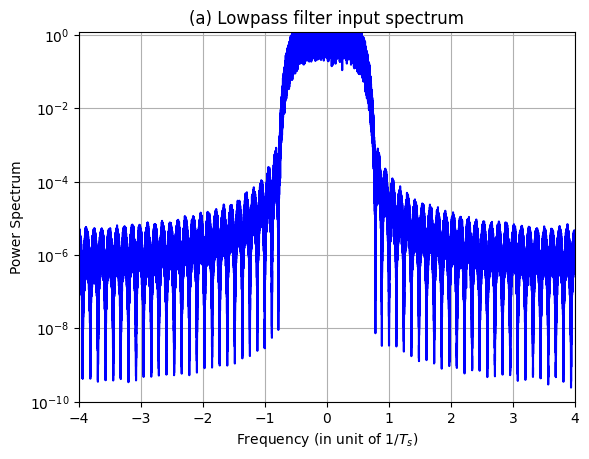

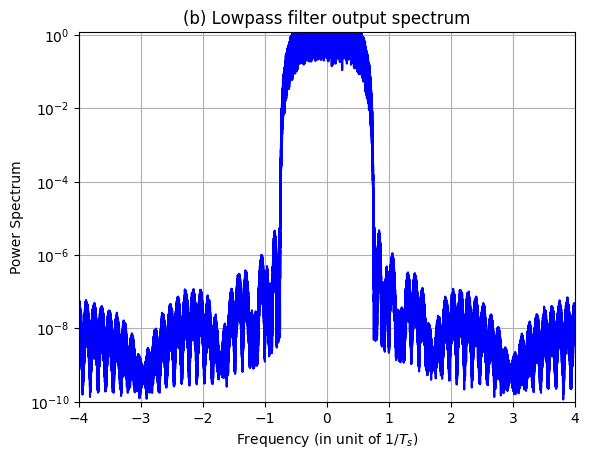

In [5]:
# Compute PSD of QAM signal before and after chebyshev lowpass filter
the_hamming_window = get_window('hamming',
                                np.floor(len(xchout)/4.5).astype(int))
# Default Length of the FFT (nfft) is the greater of 256
# or the next power of 2 greater than the length of the segments.
nfft = max(256, 2**np.ceil(np.log2(len(the_hamming_window))))

fq, Pdfy = welch(xchout,fs=f_ovsamp,
             window=the_hamming_window,nfft=nfft,scaling='density',
             return_onesided=False,detrend=False)
fq = np.fft.fftshift(fq)/f_ovsamp*8

fp, Pdfx = welch(xrcos,fs=f_ovsamp,
             window=the_hamming_window,nfft=nfft,scaling='density',
             return_onesided=False,detrend=False)
fp = np.fft.fftshift(fp)/f_ovsamp*8

fig1 = plt.figure()
plt.semilogy(fp,np.fft.fftshift(Pdfx),'b-')
plt.axis([-4, 4, 1.e-10, 1.2e0]); plt.grid()
plt.xlabel(r'Frequency (in unit of $1/T_s$)');plt.ylabel('Power Spectrum')
plt.title('(a) Lowpass filter input spectrum');plt.show()

plt.semilogy(fq,np.fft.fftshift(Pdfy),'b-')
plt.axis([-4, 4, 1.e-10, 1.2e0]); plt.grid()
plt.xlabel(r'Frequency (in unit of $1/T_s$)');plt.ylabel('Power Spectrum')
plt.title('(b) Lowpass filter output spectrum')
plt.show()

# 11.12.2 Computer Exercise 11.2: 16-QAM Linear Equalization

<span style="color:red"> <b>*Refer to the corresponding section in the Textbook.*</b></span>

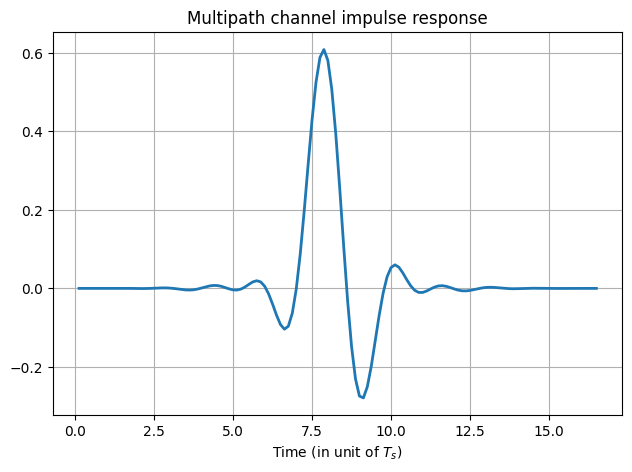

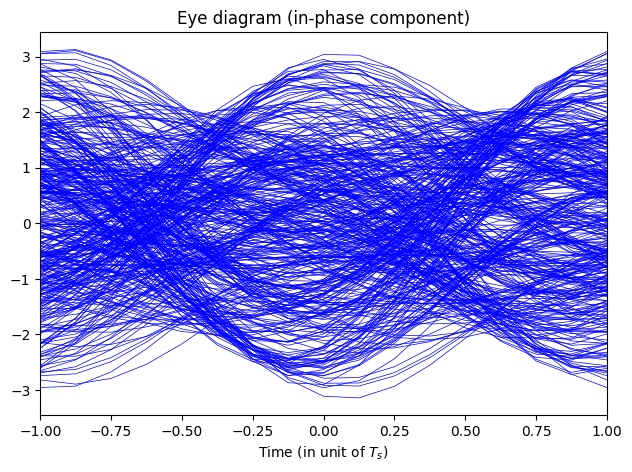

In [6]:
# Apply a 2-ray multipath channel  delta(t)-0.65 delta(t-3T/8
mpath = [1, 0, 0, -0.65]  # multipath delta(t)-0.65 delta(t-3T/8)
# time-domain multipath channel
h = np.convolve(np.convolve(prcos, pcmatch), mpath)
hscale = np.linalg.norm(h)
xchout = np.convolve(mpath, xchout)  # apply 2-ray multipath
# send the signal through matched filter separately from the noise
xrxout = np.convolve(xchout, pcmatch)
delaychb = delayrc + 3
out_mf = xrxout[delaychb:delaychb+L*f_ovsamp:f_ovsamp]; del xrxout

# generate complex random noise for channel output
noiseq = np.random.randn(L*f_ovsamp) + 1j*np.random.randn(L*f_ovsamp)
# send AWGN noise into matched filter first
noiseflt = lfilter(pcmatch,np.ones([1]),noiseq); del noiseq
# generate sampled noise after matched filter before scaling it
# and adding to the QAM signal
noisesamp = noiseflt[:L*f_ovsamp:f_ovsamp]; del noiseflt
Es = 10*hscale # symbol energy

# Plot the multipath channel impulse response
figa = plt.figure(); figa.subplots_adjust(hspace=0.5,wspace=0.4)
t=len(h);   plt.plot(np.arange(1,t+1)/f_ovsamp,h,linewidth=2)
plt.xlabel(r'Time (in unit of $T_s$)'); plt.grid()
plt.title('Multipath channel impulse response')
plt.tight_layout(pad=1.0); plt.show();

# Plot eye diagrams due to multipath channel
eyevec=np.convolve(xchout,prcos)
eyevec=eyevec[delaychb:delaychb+800*f_ovsamp]
figb= eyeplot(np.real(eyevec),2,8)
plt.title('Eye diagram (in-phase component)')
plt.xlabel(r'Time (in unit of $T_s$)')
plt.tight_layout(pad=1.0); plt.show()

# Call linear equalizer receiver to work
# This is the receiver part of the QAM equalization example
Ntrain = 200 # Number of training symbols for Equalization
Neq = 8 # Order of linear equalizer (=length-1)
u = 0 # equalization delay u must be <= Neq
SERneq = []; SEReq = []; Eb2N = []
for i in range(14):
    Eb2N.append(i*2) # Eb/N in dB
    Eb2N_num = 10**(Eb2N[i]/10) # Eb/N in numeral
    Var_n = Es/(2*Eb2N_num) # 1/SNR is the noise variance
    signois = np.sqrt(Var_n/2) # standard deviation
    z1 = out_mf + signois*noisesamp # add noise

    # Signal matrix for computing R
    Z = toeplitz(z1[Neq:Ntrain], z1[Neq::-1])

    dvec = s_data[Neq-u:Ntrain-u] # build training data vector
    # Equalizer tap vector
    f = np.linalg.pinv(np.conjugate(Z).T @ Z) @ np.conjugate(Z).T @ dvec
    dsig = np.convolve(f.flatten(), z1) # apply FIR equalizer
    # Decision based on the Re/Im parts of the samples
    deq = np.sign(np.real(dsig[:L])) + np.sign(np.real(dsig[:L])-2) + \
    np.sign(np.real(dsig[:L])+2) + 1j*(np.sign(np.imag(dsig[:L])) +
            np.sign(np.imag(dsig[:L])-2) + np.sign(np.imag(dsig[:L])+2))
    # Now compare against the original data to compute SER
    # (1) for the case without equalizer
    dneq = (np.sign(np.real(z1[:L])) + np.sign(np.real(z1[:L])-2) +
            np.sign(np.real(z1[:L])+2) +
            1j*(np.sign(np.imag(z1[:L])) + np.sign(np.imag(z1[:L])-2) +
                np.sign(np.imag(z1[:L])+2)))
    SERneq.append(np.sum(np.abs(s_data[:L].flatten() != dneq))/L)
    # (2) for the case with equalizer
    SEReq.append(np.sum(s_data[:L].flatten() != deq)/L)
Eb2Naz = np.zeros(10); Q = np.zeros(10)
for ii in range(10):
    Eb2Naz[ii] = 2 * ii    # Compute the Analytical BER
    Q[ii] = 3 * 0.5 * erfc(np.sqrt((2 * 10**(Eb2Naz[ii] * 0.1) / 5) / 2))

Current Eb/No= 26


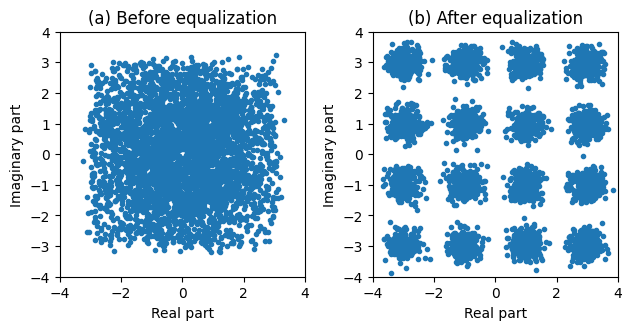

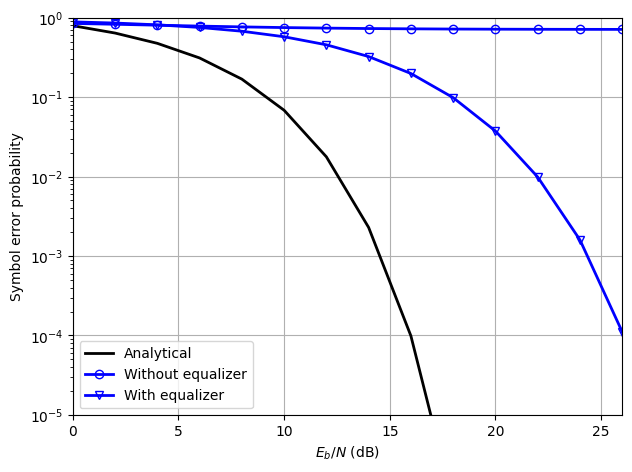

In [7]:
# Constellation plot before and after linear equalization at Eb/N0
print('Current Eb/No=',Eb2N[-1])
figc = plt.figure();figc.subplots_adjust(hspace=0.5,wspace=0.4);
plt.subplot(121); plt.axis('square'); plt.axis([-4,4,-4,4])
plt.plot(np.real(z1[1:min(L,4000)]),np.imag(z1[1:min(L,4000)]),'.')
plt.xlabel('Real part'); plt.ylabel('Imaginary part')
plt.title('(a) Before equalization')
plt.subplot(122); plt.axis('square'); plt.axis([-4,4,-4,4])
plt.plot(np.real(dsig[1:min(L,4000)]),np.imag(dsig[1:min(L,4000)]),'.')
plt.xlabel('Real part'); plt.ylabel('Imaginary part')
plt.title('(b) After equalization')
plt.tight_layout(pad=1.0); plt.show()

# Plot symbol error rate comparison before and after equalization
figd = plt.figure(); figd.subplots_adjust(hspace=0.5,wspace=0.4)
plt.subplot(111)
figber=plt.semilogy(Eb2Naz,Q,'k-',Eb2N,SERneq,'b-o',
                    Eb2N,SEReq,'b-v',mfc='none',linewidth=2)
plt.axis([0, 26, .99e-5, 1]); plt.grid()
plt.legend(['Analytical', 'Without equalizer', 'With equalizer'])
plt.xlabel(r'$E_b/N$ (dB)'); plt.ylabel('Symbol error probability')
# Set the spacing between subfigures
plt.tight_layout(pad=1.0); plt.show()




# 11.12.3 Computer Exercise 11.3: Decision Feedback Equalization

<span style="color:red"> <b>*Refer to the corresponding section in the Textbook. This code may take some time to run.*</b></span>


In [14]:
'''This Python exercise performs simulation of linear equalization under
16-QAM baseband transmission a multipath channel with AWGN. Correct carrier
and synchronization is assumed. Root-raised cosine pulse of rolloff factor = 0.5
is used. Matched filter is applied at receiver front end. The program estimates
the symbol error rate (SER) at different Eb/N'''
L = 200000 # Total data symbols in experiment is 200 thousand
# To display pulseshape, we oversample signal by a factor f_ovsamp = 8
f_ovsamp = 8  # Oversampling factor vs data rate
delay_rc = 4
# Generating root-raised cosine pulseshape (rolloff factor = 0.5)
prcos = np.convolve(np.array([1]),
                rcosdesign(beta = 0.5, span = delay_rc*2, sps = f_ovsamp))
prcos /= np.linalg.norm(prcos)  # normalize
pcmatch = prcos[::-1]  # MF
# Generating random signal data for polar signaling
s_data = (4 * np.round(np.random.rand(L, 1)) +
          2 * np.round(np.random.rand(L, 1)) - 3) \
         + 1j * (4 * np.round(np.random.rand(L, 1)) +
                 2 * np.round(np.random.rand(L, 1)) - 3)
# upsample to match the 'oversampling rate' (normalize by 1/T).
# It is f_ovsamp/T (T=1 is the symbol duration)
s_up = np.stack([s_data] +[s_data*0] * (f_ovsamp-1),axis=-1).reshape(-1)
# Identify the decision delays due to pulse shaping & matched filters
delayrc = 2 * delay_rc * f_ovsamp
# Generate polar signaling of different pulse-shaping
xrcos = np.convolve(s_up, prcos)
(c_num, c_den) = cheby2(12, 20, (1 + 0.5)/8,
                        'lowpass', analog=False, output='ba')
# The lowpass filter is the Tx filter before signal is sent to channel
xchout = lfilter(c_num, c_den, xrcos)

Note: This code may take several minutes to complete.


In [15]:
# Apply a 2-ray multipath channel delta(t)-0.83 delta(t-3T/8)
mpath=[1, 0, 0, -0.87]   # May use easier mpath=[1, 0, 0, .45];
print('Be Patient: This code may take several minutes to complete...')
# time-domain multipath channel
h = np.convolve(np.convolve(prcos, pcmatch), mpath)
hscale = np.linalg.norm(h)
xchout = np.convolve(mpath, xchout)  # apply 2-ray multipath
# send the signal through matched filter separately from the noise
xrxout = np.convolve(xchout, pcmatch)
delaychb = delayrc + 3
out_mf = xrxout[delaychb:delaychb+L*f_ovsamp:f_ovsamp]; del xrxout
# generate complex random noise for channel output
noiseq = np.random.randn(L*f_ovsamp) + 1j*np.random.randn(L*f_ovsamp)

# send AWGN noise into matched filter first
noiseflt = lfilter(pcmatch,np.ones([1]),noiseq); del noiseq
# generate sampled noise after matched filter before scaling; add to QAM signal
noisesamp = noiseflt[:L*f_ovsamp:f_ovsamp]; del noiseflt
Es = 10*hscale # symbol energy
# Next is the receiver part of the QAM equalization that uses DFE

Ntrain = 200  # Number of training symbols for channel estimation h_hat
Nch = 3  # Order of FIR channel (=length-1)
Neq = 8 # Order of linear equalizer (=length-1)
u = 0 # select equalization delay u must be <= Neq

SEReq = []; SERneq = []; SERdfe = []; Eb2N = []
for i in range(1, 16):
    Eb2N.append(i*2) # (Eb/N in dB)
    Eb2N_num = 10**(Eb2N[i-1]/10) # Eb/N in numeral
    Var_n = Es/(2*Eb2N_num) # 1/SNR is the noise variance
    signois = np.sqrt(Var_n/2) # standard deviation
    z1 = out_mf + signois*noisesamp # add noise

    # signal matrix for computing R
    Z = toeplitz(s_data[Nch:Ntrain], s_data[Nch::-1])
    dvec = z1[Nch:Ntrain]  # build training data vector
    h_hat = np.linalg.pinv(np.conjugate(Z).T @ Z) @ \
        np.conjugate(Z).T @ dvec  # find channel estimate tap vector
    z1 = z1/h_hat[0]  # equalize the gain loss
    h_hat = h_hat[1:]/h_hat[0]  # set the leading tap to 1
    del Z, dvec

    # Signal matrix for computing R for equalizer
    Z_eq = toeplitz(z1[Neq:Ntrain], z1[Neq::-1])
    # build training data vector for linear equalizer
    dvec_eq = s_data[Neq-u: Ntrain-u]
    f = np.linalg.pinv(np.conjugate(Z_eq).T @ Z_eq) @ \
        np.conjugate(Z_eq).T @ dvec_eq # equalizer tap vector
    dsig_eq = np.convolve(f.flatten(), z1) # apply FIR equalizer
    del Z_eq, dvec_eq, f

    # Decision based on the Re/Im parts of the samples
    deq = np.sign(np.real(dsig_eq[:L])) + np.sign(np.real(dsig_eq[:L])-2)+\
          np.sign(np.real(dsig_eq[:L])+2)+1j*(np.sign(np.imag(dsig_eq[:L]))+\
          np.sign(np.imag(dsig_eq[:L])-2)+np.sign(np.imag(dsig_eq[:L])+2))

    # Compute the SER for equlizer as comparison
    SEReq.append(np.sum(s_data.flatten() != deq)/L); del deq

    feedbk = np.zeros(Nch) #initializing 0 feedback
    dsig = np.zeros(L, dtype=complex)
    for kj in range(L):
        zfk = feedbk @ h_hat  # feedback data
        dsig[kj] = z1[kj] - zfk  # subtract the feedback
        # Now make decision after feedback
        d_temp = np.sign(np.real(dsig[kj])) + np.sign(np.real(dsig[kj])-2) + \
                 np.sign(np.real(dsig[kj])+2) +1j*(np.sign(np.imag(dsig[kj]))+\
                  np.sign(np.imag(dsig[kj])-2)+np.sign(np.imag(dsig[kj])+2))
        # update the feedback data
        feedbk = np.concatenate(([d_temp], feedbk[:-1]))
    # Now compute the entire DFE decision after decision feedback
    dfeq = np.sign(np.real(dsig))+ np.sign(np.real(dsig)-2) + \
          np.sign(np.real(dsig)+2) + 1j*(np.sign(np.imag(dsig)) +\
            np.sign(np.imag(dsig)-2) + np.sign(np.imag(dsig)+2))
    dfeq = dfeq.reshape(L, 1);
    # Compute the SER after decision feedback equalization
    SERdfe.append(np.sum(s_data != dfeq)/L); del dfeq
    # find the decision without DFE
    dneq = np.sign(np.real(z1)) + np.sign(np.real(z1)-2) + \
          np.sign(np.real(z1)+2) + 1j*(np.sign(np.imag(z1)) + \
            np.sign(np.imag(z1)-2) +np.sign(np.imag(z1)+2))
    dneq = dneq.reshape(L, 1)
    # Compute the SER without equalization
    SERneq.append(np.sum(s_data != dneq)/L); del dneq
Eb2Naz = np.zeros(10); Q = np.zeros(10)

for ii in range(10):
    Eb2Naz[ii] = 2 * ii
    # Compute the Analytical BER
    Q[ii] = 3 * 0.5 * erfc(np.sqrt((2 * 10**(Eb2Naz[ii] * 0.1) / 5) / 2))

Note: This code may take several minutes to complete.


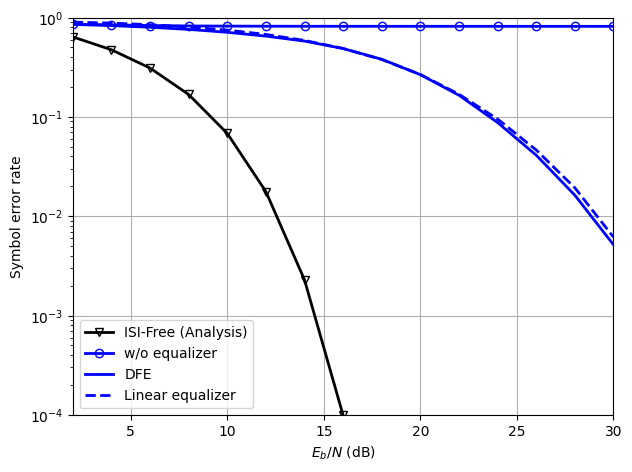

Current Eb/No= 30


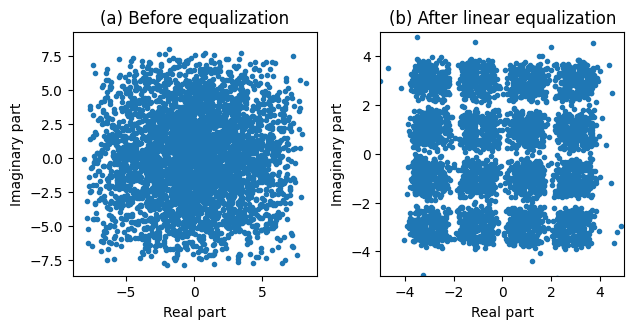

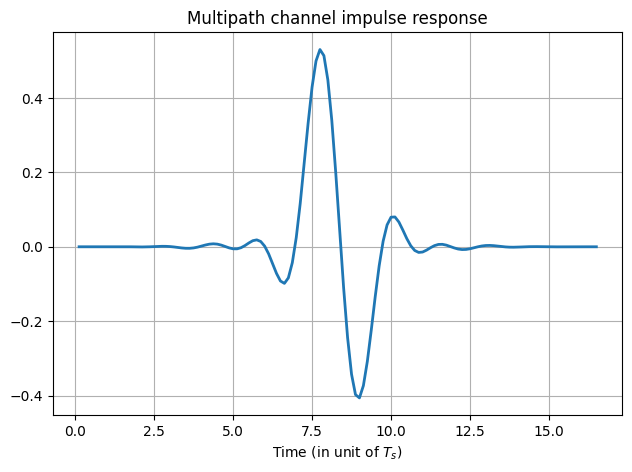

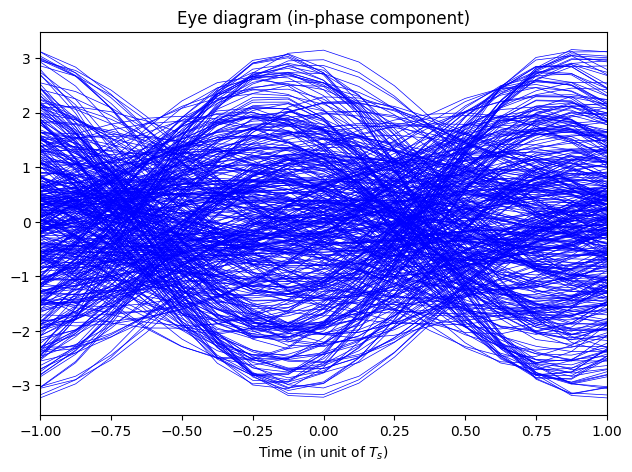

In [16]:
# Plot symbol error rate comparison before and after equalization
fig2 = plt.figure(); fig2.subplots_adjust(hspace=0.5,wspace=0.4)
plt.subplot(111)
figber=plt.semilogy(Eb2Naz,Q,'k-v',Eb2N,SERneq,'b-o',Eb2N,SERdfe,'b-',
                    Eb2N,SEReq,'b--',mfc='none',linewidth=2)
plt.axis([2, 30, .99e-4, 1]); plt.grid()
plt.legend(['ISI-Free (Analysis)', 'w/o equalizer', 'DFE', 'Linear equalizer'])
plt.xlabel(r'$E_b/N$ (dB)'); plt.ylabel('Symbol error rate')
plt.tight_layout(pad=1.0); plt.show()

# Constellation plot before and after linear equalization at Eb/N0
print('Current Eb/No=',Eb2N[-1])
fig3 = plt.figure(); fig3.subplots_adjust(hspace=0.5,wspace=0.4)
plt.subplot(121)
plt.plot(np.real(z1[1:min(L,4000)]),np.imag(z1[1:min(L,4000)]),'.')
plt.title('(a) Before equalization'); plt.axis('square')
plt.xlabel('Real part'); plt.ylabel('Imaginary part')

plt.subplot(122)
plt.plot(np.real(dsig[1:min(L,4000)]),np.imag(dsig[1:min(L,4000)]),'.')
plt.title('(b) After linear equalization');plt.axis('square'); plt.axis([-5,5,-5,5])
plt.xlabel('Real part'); plt.ylabel('Imaginary part')
plt.tight_layout(pad=1.0); plt.show()

fig4 = plt.figure();fig4.subplots_adjust(hspace=0.5,wspace=0.4);t=len(h)
plt.plot(np.arange(1,t+1)/f_ovsamp,h,linewidth=2);plt.grid()
plt.xlabel(r'Time (in unit of $T_s$)')
plt.title('Multipath channel impulse response')
plt.tight_layout(pad=1.0); plt.show()

# Plot eye diagrams due to multipath channel
eyevec=np.convolve(xchout,prcos)
eyevec=eyevec[delaychb:(delaychb+800)*f_ovsamp]
_ = eyeplot(np.real(eyevec),2,8)
plt.title('Eye diagram (in-phase component)')
plt.xlabel(r'Time (in unit of $T_s$)')
plt.tight_layout(pad=1.0); plt.show()

<img src="images/Fig11_24.png" width="600" />

<center><b>Figure 11.24</b> Symbol error rate (SER) comparison of DFE, linear equalization, and under ideal channel. </center>

# 11.12.3 Computer Exercise 11.3: OFDM Transmission of QAM Signals
<span style="color:red"> <b>*Refer to the corresponding section in the Textbook.*</b></span>


In [11]:
# This Python exercise performs simulation of an OFDM system using 16-QAM
# baseband signaling over a multipath channel with AWGN. Correct carrier and
# synchronization is assumed. 32 subcarriers are used with a channel length of 6
# and cyclic prefix length of 5.
L = 2000000 # Total data symbols in experiment is 2 million
Lfr = L // 32 # Number of data frames

# Generate random signal data for polar signaling
s_data = 4*np.round(np.random.rand(L, 1))+2*np.round(np.random.rand(L, 1))-3+\
      1j*(4 * np.round(np.random.rand(L,1))+2 * np.round(np.random.rand(L,1))-3)
channel = np.array([0.3, -0.5, 0, 1, 0.2, -0.3])  # Channel in time-domain
hf = np.fft.fft(channel, 32)  # Find the channel in frequency domain
p_data = np.reshape(s_data, (32, Lfr), order='F') # S/P conversion
p_td = np.fft.ifft(p_data, axis=0)  # IDFT to convert to time-domain
p_cyc = np.vstack((p_td[-5:, :], p_td)) # Add cyclic prefix
s_cyc = np.reshape(p_cyc, (37 * Lfr, 1), order='F') # P/S conversion

Psig = 10 / 32 # Average channel input power
# Generate channel output signal
chsout = lfilter(channel, 1, s_cyc.flatten())
del p_td, p_cyc, s_data, s_cyc # release some memory

In [12]:
# Add noise
SEReq = []; SNR = []
noiseq = np.random.randn(37 * Lfr) + 1j * np.random.randn(37 * Lfr)
for ii in range(31):
    SNR.append(ii) # SNR in dB
    Asig = np.sqrt(Psig * 10 ** (-SNR[ii] / 10)) * np.linalg.norm(channel)
    x_out = chsout + Asig * noiseq # Add noise
    x_para = np.reshape(x_out, (37, Lfr), order='F') # S/P conversion
    x_disc = x_para[5:, :] # Discard cyclic prefix
    xhat_para = np.fft.fft(x_disc, axis=0) # FFT back to frequency domain
    z_data = np.diag(1.0 / hf) @ xhat_para # Frequency-domain equalizing
    # Compute the QAM decision after equalization
    deq = np.sign(np.real(z_data)) + np.sign(np.real(z_data) - 2) + \
        np.sign(np.real(z_data) + 2) + 1j * (np.sign(np.imag(z_data)) +
            np.sign(np.imag(z_data) - 2) + np.sign(np.imag(z_data) + 2))
    # Compute symbol error rate (SER)
    SEReq.append(np.sum(p_data != deq, axis=1) / Lfr)
SEReq = np.array(SEReq).T
# Compute the analytical BER
SNRa = np.arange(0, 18, 2)
Q = 3 * 0.5 * erfc(np.sqrt((2 * 10**(SNRa * 0.1) / 5) / 2))

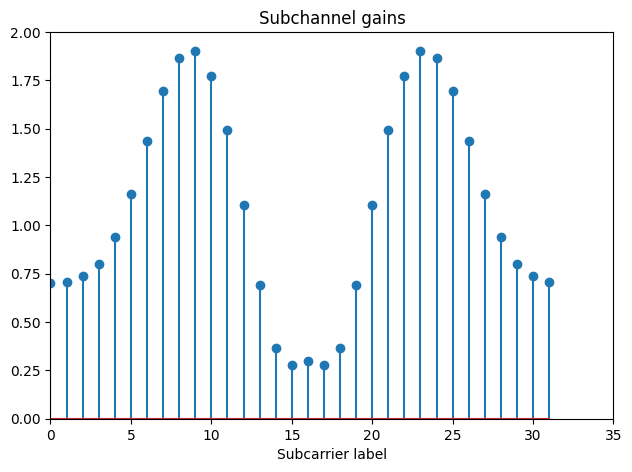

<Figure size 640x480 with 0 Axes>

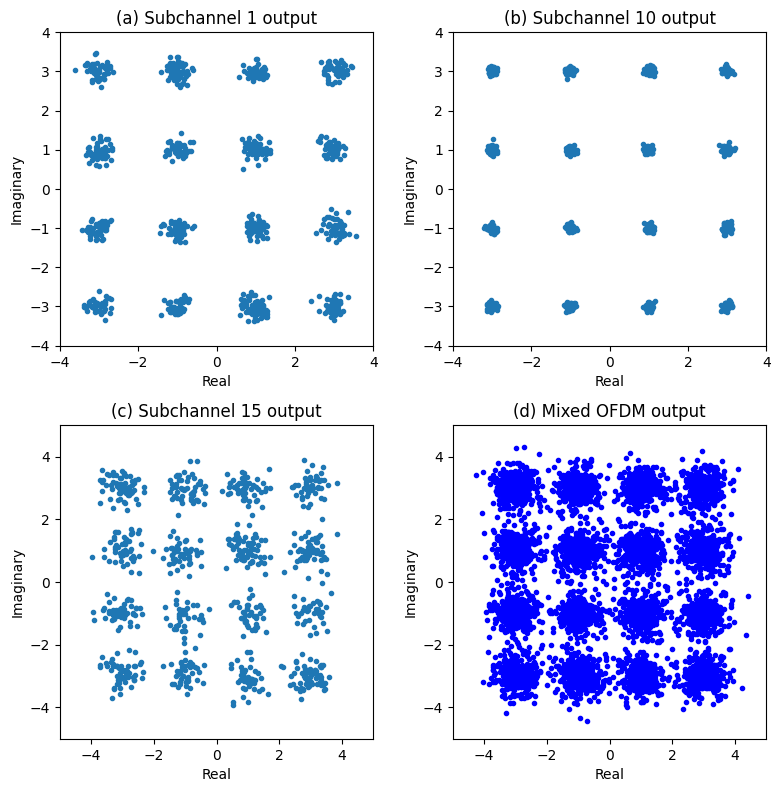

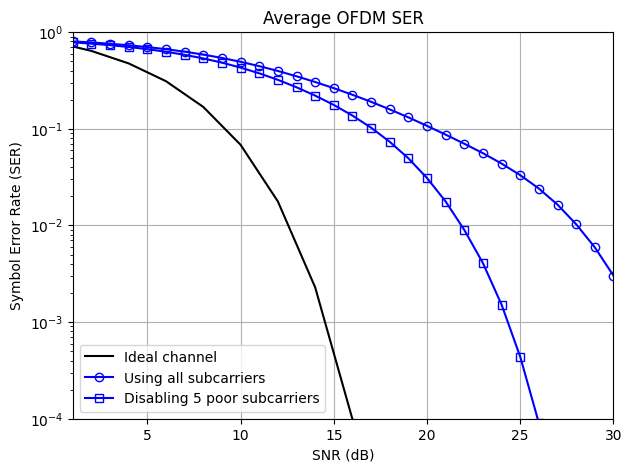

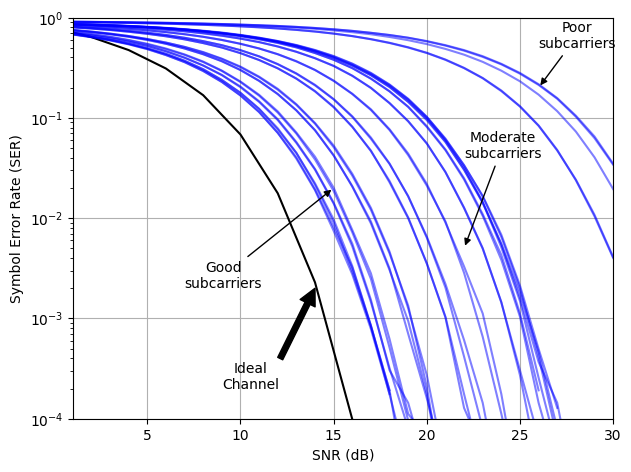

In [13]:
# This Python cell analyzes OFDM subcarriers and their receiver outputs.
# First show subcarrier gains
fig1 = plt.figure(); fig1.subplots_adjust(hspace=0.5,wspace=0.4)
plt.stem(np.abs(hf)); plt.axis([0, 35, 0, 2])
plt.xlabel('Subcarrier label'); plt.title('Subchannel gains')
plt.tight_layout(pad=1.0); plt.show()

# Plot the subchannel constellation scattering after OFDM
fig2 = plt.figure(); plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(np.real(z_data[0,:800]),np.imag(z_data[0,:800]),'.')
# subchannel 1 output
plt.axis('square'); plt.axis([-4, 4, -4, 4])
plt.xticks(ticks=[-4, -2, 0, 2, 4]); plt.xlabel('Real'); plt.ylabel('Imaginary')
plt.title('(a) Subchannel 1 output')
plt.subplot(222)
plt.plot(np.real(z_data[9,:800]),np.imag(z_data[9,:800]),'.')
# subchannel 10 output
plt.axis('square'); plt.axis([-4, 4, -4, 4])
plt.xticks(ticks=[-4, -2, 0, 2, 4]); plt.xlabel('Real'); plt.ylabel('Imaginary')
plt.title('(b) Subchannel 10 output')
plt.subplot(223)
plt.plot(np.real(z_data[14,:800]),np.imag(z_data[14,:800]),'.')
# subchannel 15 output
plt.axis('square'); plt.axis([-5, 5, -5, 5])
plt.xticks(ticks=[-4, -2, 0, 2, 4]); plt.xlabel('Real'); plt.ylabel('Imaginary')
plt.title('(c) Subchannel 15 output')
plt.subplot(224)
plt.plot(np.real(z_data[:,:800]),np.imag(z_data[:,:800]),'b.')
# mixed subchannel output
plt.axis('square'); plt.axis([-5, 5, -5, 5])
plt.xticks(ticks=[-4, -2, 0, 2, 4]); plt.xlabel('Real'); plt.ylabel('Imaginary')
plt.title('(d) Mixed OFDM output')

# Set the spacing between subfigures
plt.tight_layout(pad=1.0); plt.show()
# Plot the average OFDM SER versus SER under "ideal channel"
# By Disabling 5 poor subcarriers, average SER can be reduced.
SEReq_poor_disabled = np.mean(np.concatenate((SEReq[:14], \
                                      SEReq[19:32])),axis=0)
    # replace 0 in SER with 'nan' to mask 0 value when plotting in logscale
SEReq_poor_disabled[SEReq_poor_disabled==0] = np.nan
fig3 = plt.figure(); fig3.subplots_adjust(hspace=0.5,wspace=0.4)
figc=plt.semilogy(SNRa,Q,'k-',SNR, np.mean(SEReq,axis=0),'b-o',
                  SNR, SEReq_poor_disabled,'b-s', mfc='none')
plt.legend(['Ideal channel','Using all subcarriers',\
            'Disabling 5 poor subcarriers'])
plt.axis([1, 30, 1.e-4, 1]); plt.grid()
plt.xlabel('SNR (dB)'); plt.ylabel('Symbol Error Rate (SER)')
plt.title('Average OFDM SER')
plt.tight_layout(pad=1.0); plt.show()
# Plot the SER of each subcarrier versus SER under "ideal channel"
from matplotlib.patches import Ellipse

fig4, ax = plt.subplots()
fig4.subplots_adjust(hspace=0.5,wspace=0.4)
figc=plt.semilogy(SNRa,Q,'k-')
for SER in SEReq:
    # replace 0 in SER with 'nan' to mask 0 value when plotting in logscale
    SER[SER==0] = np.nan;
    plt.semilogy(SNR, SER,'b-',alpha=0.5)
plt.axis([1, 30, 1.e-4, 1]); plt.grid()
plt.xlabel('SNR (dB)'); plt.ylabel('Symbol Error Rate (SER)')
plt.annotate('Poor\nsubcarriers', xy=(26,0.2), xytext=(26,0.5),
          arrowprops=dict(arrowstyle="-|>",facecolor='black'),ma='center')
plt.annotate('Moderate\nsubcarriers', xy=(22,0.005), xytext=(22,4e-2),
          arrowprops=dict(arrowstyle="-|>",facecolor='black'),ma='center')
plt.annotate('Good\nsubcarriers', xy=(15,2e-2), xytext=(7,2e-3),
          arrowprops=dict(arrowstyle="-|>",facecolor='black'),ma='center')
plt.annotate('Ideal\nChannel', xy=(14,0.002), xytext=(9,2e-4),
          arrowprops=dict(facecolor='black'),ma='center')
plt.tight_layout(pad=1.0); plt.show()

<img src="images/Fig11_25.png" width="600" />

<center><b>Figure 11.25</b> Comparison of the in channel gain for 32 subcarriers. </center>
<img src="images/Fig11_26.png" width="600" />

<center><b>Figure 11.26</b> Difference in channel quality as shown by scatter plots of the following OFDM channel
outputs: (a) subchannel 1, (b) subchannel 10, (c) subchannel 15, and (d) mixed. </center>
<img src="images/Fig11_27.png" width="600" />

<center><b>Figure 11.27</b> Symbol error rate (SER) of all 32 subcarriers over the multipath channel. </center>
<img src="images/Fig11_28.png" width="600" />

<center><b>Figure 11.28</b> Average SER of the OFDM subcarriers before and after disabling five worst channels.</center>
